In [21]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import data
from skimage import filters
import time
from skimage import io, morphology
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc

In [22]:
path_to_train_images = 'train_BloodVessel/'       #Path to the directory containing the train images
path_to_train_manual = 'manual/'   #Path to the directory containing the groundtruth/manual for train images

In [23]:
def getImage_train(img_num):
    path = path_to_train_images
    name = str(img_num)+'_training.tif'
    full_path = path + name
    image = cv.imread(full_path, -1)
    return image

In [24]:
def getManual_train(man_num):
    path = path_to_train_manual
    name = str(man_num)+'_manual1.gif'
    full_path = path + name
    man_gif = Image.open(full_path)
    man_gif = np.array(man_gif, dtype=np.uint8)

    return man_gif

In [25]:
def imgResize(img):
    h = img.shape[0]
    w = img.shape[1]
    perc = 300/w
    w1 = 300
    h1 = int(h*perc)
    img_rd = img
    return img_rd

In [26]:
def getContours1(img, thresh):
    mask1 = np.ones(img.shape, dtype="uint8") * 255
    cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    for i in cnts0:
        if cv.contourArea(i) <= thresh:
            cv.drawContours(mask1, [i], -1, 0, 1)
    mask1 = cv.bitwise_and(img, img, mask = mask1)
    return mask1

In [27]:
def removeObjects(img, thresh):
    arr = img < 255
    img_cln = morphology.remove_small_holes(arr, area_threshold=thresh)
    img_cln = img_cln.astype('uint8')
    img_cln[img_cln == 1] = 255
    _,img_clean = cv.threshold(img_cln,20,255,cv.THRESH_BINARY_INV)
    return img_clean

Image Number:  1


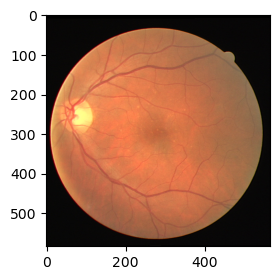

In [28]:
img = getImage_train(21)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print("Image Number: ", 1)
img_rd = imgResize(img)
plt.figure(figsize=(3,3))
plt.imshow(img_rd)
plt.show()

Step 1: Green Channel of original Image

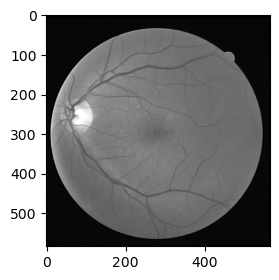

In [29]:
_,img_gc,_ = cv.split(img_rd) 
plt.figure(figsize=(3,3))
plt.imshow(img_gc,cmap = 'gray')
plt.show()

Step 2 : Apply CLAHE

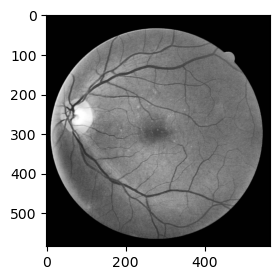

In [30]:
img_gc[img_gc<=30] = 0
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(3,3)) 
img_cl1 = clahe.apply(img_gc)
plt.figure(figsize=(3,3))
plt.imshow(img_cl1,cmap = 'gray')
plt.show()

Step 3 : Alternative Sequential Filtering

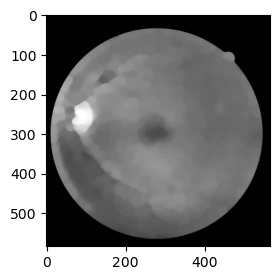

In [31]:
def altSeqFilter(img):
    kernels = [(5,5), (7,7), (15,15), (11,11)]
    img_close=img.copy()
    for alt_seq in range(4):
        img_open = cv.morphologyEx(img_close, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,kernels[alt_seq]), iterations = 1)
        img_close = cv.morphologyEx(img_open, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,kernels[alt_seq]), iterations = 1)
    return img_close
img_alt = altSeqFilter(img_cl1)
plt.figure(figsize=(3,3))
plt.imshow(img_alt,cmap = 'gray')
plt.show()

Step 4 : Subtract result image from step 3 and step 2

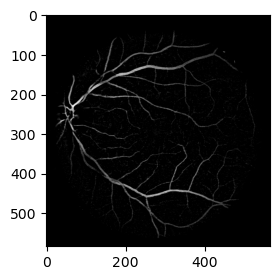

In [32]:
img_sub = cv.subtract(img_alt, img_cl1)
plt.figure(figsize=(3,3))
plt.imshow(img_sub,cmap = 'gray')
plt.show()

Step 5: Again Apply CLAHE

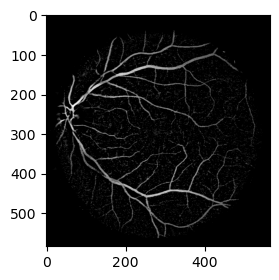

In [33]:
clahe2 = cv.createCLAHE(clipLimit=16.0, tileGridSize=(2,2))  #step5 : Again apply CLAHE
img_cl2 = clahe2.apply(img_sub)
plt.figure(figsize=(3,3))
plt.imshow(img_cl2,cmap = 'gray')
plt.show()

Step6: Median filter with kernel size (3,3) and then thresholding

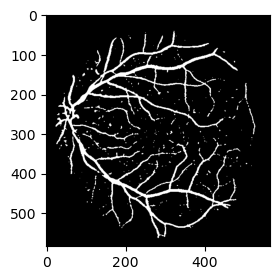

In [34]:
img_mdf = cv.medianBlur(cv.GaussianBlur(img_cl2,(3,3),0), 3)
_,img_adth = cv.threshold(img_mdf,30,255, cv.THRESH_BINARY)
plt.figure(figsize=(3,3))
plt.imshow(img_adth,cmap = 'gray')
plt.show()

Step7: Contour Detection

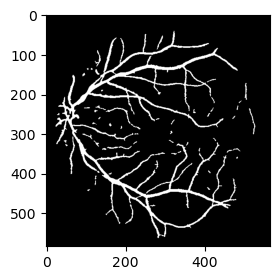

In [35]:
def getContours1(img, thresh):
    mask1 = np.ones(img.shape, dtype="uint8") * 255
    cnts0, hier0 = cv.findContours(img.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    for i in cnts0:
        if cv.contourArea(i) <= thresh:
            cv.drawContours(mask1, [i], -1, 0, 1)
    mask1 = cv.bitwise_and(img, img, mask = mask1)
    return mask1
img_clth = getContours1(img_adth, 8)         
img_clth = getContours1(img_clth, 1)
plt.figure(figsize=(3,3))
plt.imshow(img_clth,cmap = 'gray')
plt.show()

Calculating accuracy by comparing with the manual image

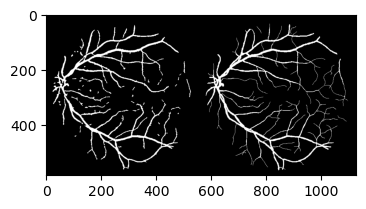

In [36]:
man = getManual_train(21)                                           
unique, counts = np.unique(man, return_counts=True)
img_stack = np.hstack([img_clth, man])
plt.figure(figsize=(4,4))
plt.imshow(img_stack,cmap = 'gray')
plt.show()

In [43]:
def calc_cmat(mat):
    tn, fp, fn, tp = mat[0], mat[1], mat[2], mat[3]
    acc = (tp+tn)/(tp+fn+fp+tn)
    spcf = tn/(tn+fp)
    sens = tp/(tp+fn)
    f1s = 2*tp/(2*tp+fp+fn)
    return acc, spcf, sens, f1s, tp, fp

mat = confusion_matrix(man.flatten(), img_clth.flatten())
a, sp, sn, f1, tp, fp = calc_cmat(mat.flatten())
print("Accuracy : ",a*100)
print("Specificity : ",sp*100)
print("Sensitivity : ",sn*100)
print("F1 Score : ",f1)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Accuracy :  96.29985452782155
Specificity :  97.73149833256274
Sensitivity :  78.83684652613896
F1 Score :  0.7635243758352863


Entire Dataset

Image Number : 1
Accuracy : 96.62565159413262
Specificity : 97.87685635862195
Sensitivity : 81.13391191499716
F1 Score : 0.7823094670159935

Image Number : 2
Accuracy : 96.00830403685295
Specificity : 98.08996138610233
Sensitivity : 75.04780435438961
F1 Score : 0.7725726520815707

Image Number : 3
Accuracy : 90.21790520063038
Specificity : 90.67925005758556
Sensitivity : 83.67168438981724
F1 Score : 0.5296886155998193

Image Number : 4
Accuracy : 95.1845678264032
Specificity : 98.04888750252802
Sensitivity : 73.32653221376442
F1 Score : 0.7791752949842258

Image Number : 5
Accuracy : 95.32943387077222
Specificity : 99.30068289019782
Sensitivity : 57.92415295715052
F1 Score : 0.7041977773085856

Image Number : 6
Accuracy : 96.15074554491454
Specificity : 98.34880467744975
Sensitivity : 72.04511659957204
F1 Score : 0.7577578150330911

Image Number : 7
Accuracy : 96.03042793065826
Specificity : 97.96568146845826
Sensitivity : 76.00178860110756
F1 Score : 0.7713737126898237

Image Number :

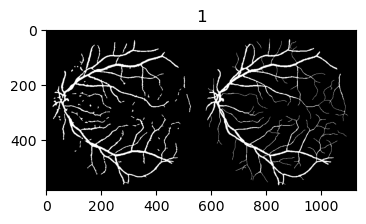

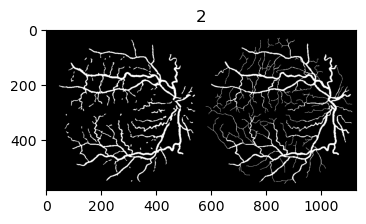

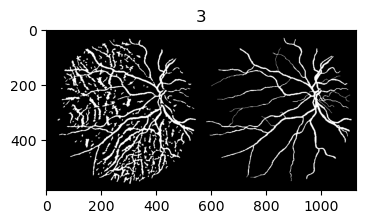

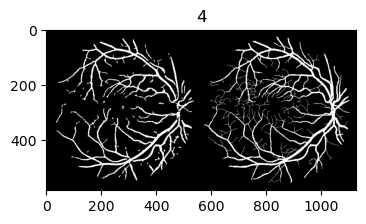

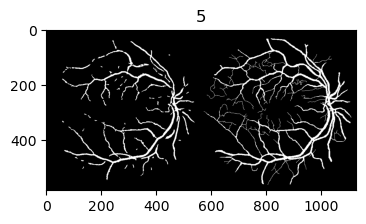

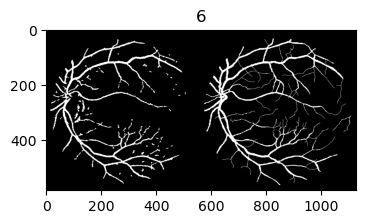

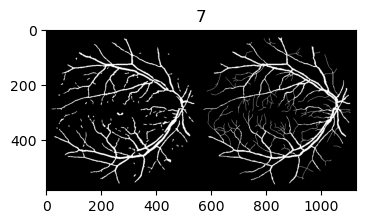

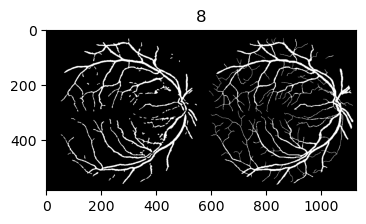

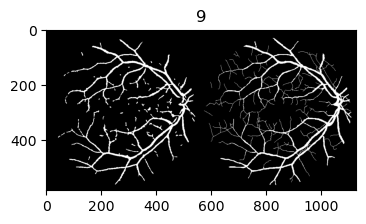

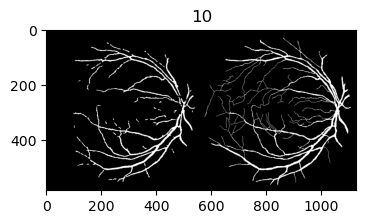

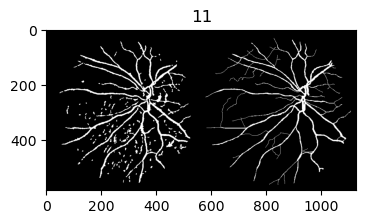

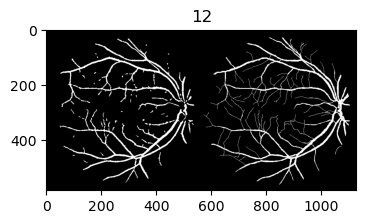

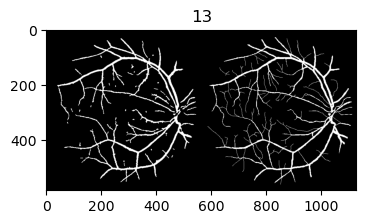

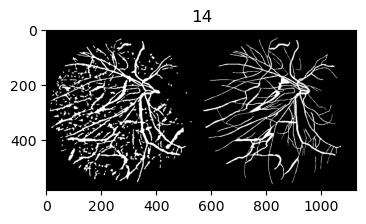

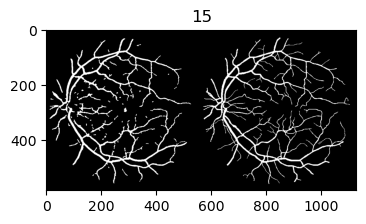

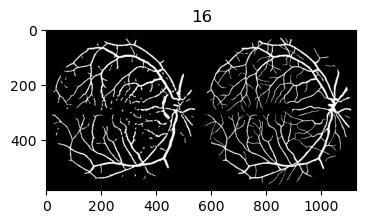

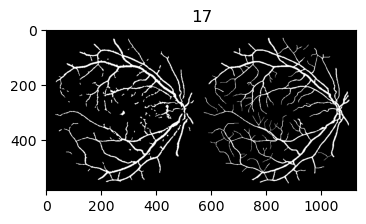

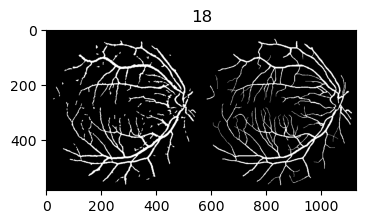

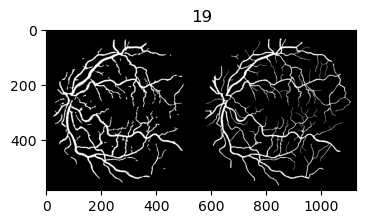

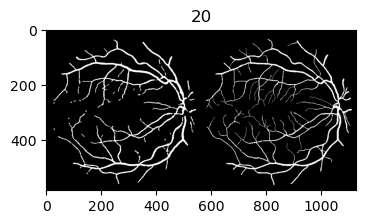

In [39]:
acc = []
spcf = []
sens = []
f1_sc = []
tp_list = []
fp_list = []
start_time = time.time()
for img_num in range(21,41):
    img = getImage_train(img_num)                                                                                              
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    print("Image Number :", img_num-20)
    img_rd = imgResize(img)
    _,img_gc,_ = cv.split(img_rd)
    img_gc[img_gc<=30] = 0
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    img_cl1 = clahe.apply(img_gc)
    img_alt = altSeqFilter(img_cl1)
    img_sub = cv.subtract(img_alt, img_cl1)
    clahe2 = cv.createCLAHE(clipLimit=16.0, tileGridSize=(2,2))
    img_cl2 = clahe2.apply(img_sub)
    img_mdf = cv.medianBlur(cv.GaussianBlur(img_cl2,(3,3),0), 3)
    _,img_adth = cv.threshold(img_mdf,30,255, cv.THRESH_BINARY)
    img_clth = getContours1(img_adth, 8)
    img_clth = getContours1(img_clth, 1)
    man = getManual_train(img_num)                                              
    unique, counts = np.unique(man, return_counts=True)
    img_stack = np.hstack([img_clth, man])
    mat = confusion_matrix(man.flatten(), img_clth.flatten())
    a, sp, sn, f1, tp, fp = calc_cmat(mat.flatten())
    acc.append(a*100)
    spcf.append(sp*100)
    sens.append(sn*100)
    f1_sc.append(f1)
    tp_list.append(tp)
    fp_list.append(fp)
    plt.figure(figsize=(4,4))
    plt.imshow(img_stack,cmap = "gray")
    plt.title(str(img_num-20))
    print("Accuracy :",a*100)
    print("Specificity :",sp*100)
    print("Sensitivity :",sn*100)
    print("F1 Score :",f1)
    print()
end_time = time.time()


In [40]:
fp_r = 1-np.array(spcf)/100
auc_dict = dict(zip(fp_r, sens))
auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[0])}
print("Accuracy List :", acc)
print("\nSpecificity List :", spcf)
print("\nSensitivity List :", sens)
print("\nDice Coefficient List :", f1_sc)
print("\nFalse Positive Rate :", fp_r)

print("")

Accuracy List : [96.62565159413262, 96.00830403685295, 90.21790520063038, 95.1845678264032, 95.32943387077222, 96.15074554491454, 96.03042793065826, 95.69766032246334, 95.94859983028246, 96.05437022669415, 95.26063765304885, 96.15892835495211, 96.40653412534853, 90.46157109952722, 96.1283185840708, 95.10395199418112, 96.0264880591587, 95.54188386471087, 95.49581767486967, 96.29985452782155]

Specificity List : [97.87685635862195, 98.08996138610233, 90.67925005758556, 98.04888750252802, 99.30068289019782, 98.34880467744975, 97.96568146845826, 98.0966103744307, 97.96002104503837, 98.79043397045476, 96.2204333326883, 97.98960973806507, 97.91244880866807, 92.12525153440184, 97.70431527669007, 97.64618670003674, 97.94433429972868, 96.96765655111565, 97.06344575149531, 97.73149833256274]

Sensitivity List : [81.13391191499716, 75.04780435438961, 83.67168438981724, 73.32653221376442, 57.92415295715052, 72.04511659957204, 76.00178860110756, 73.53543502544372, 74.04417858815899, 63.912069231957

In [41]:
print("Average Accuracy = ", sum(acc)/len(acc))
print("Average Specificity = ", sum(spcf)/len(spcf))
print("Average Sensitivity = ", sum(sens)/len(sens))
print("Average Dice Coefficient  = ", sum(f1_sc)/len(f1_sc))
print(" ")
print("Total Execution Time :", (end_time - start_time),"s")
print("Average Execution Time :", (end_time - start_time)/len(acc),"s")

Average Accuracy =  95.30658261607466
Average Specificity =  97.22311850281599
Average Sensitivity =  75.44351696168185
Average Dice Coefficient  =  0.7374895220032343
 
Total Execution Time : 10.121006488800049 s
Average Execution Time : 0.5060503244400024 s


Performance measure per Image

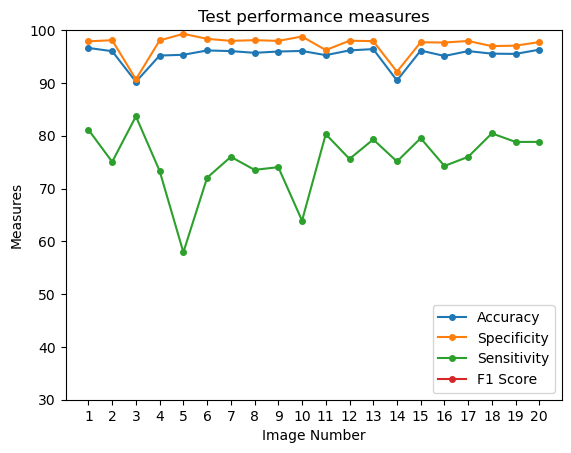

In [23]:
images   = range(1,21)
plt.plot(images, acc,'o-', markersize=4,label = "Accuracy")
plt.plot(images, spcf, 'o-',markersize=4,label = "Specificity" )
plt.plot(images, sens,'o-', markersize=4,label = "Sensitivity" )
plt.plot(images, f1_sc, 'o-',markersize=4,label = "F1 Score" )
plt.legend(loc='lower right')
plt.xlabel("Image Number")
plt.xticks(images)
plt.ylabel("Measures")
plt.ylim(min(sens)-10,100)
plt.yticks(range(30,101,10))
plt.title ('Test performance measures')
plt.show()

In [24]:
avg = (np.add(np.add(np.add(acc, spcf), sens),f1_sc))/4
print("Best Performing Image :", np.where(avg == max(avg))[0][0]+1)
print("Worst Performing Image :", np.where(avg == min(avg))[0][0]+1)

Best Performing Image : 1
Worst Performing Image : 5
